# Twitter Data Network analysis
## Gary Moore

In [206]:
from collections import Counter
import json, itertools
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Follower Network

In a follower network each node is a user (In this case twitter account) and each edge is directed to show that origin node follows the node it is pointing to.

First the list of accounts and who they are following is taken from the 'friendship.csv' file and added to a dataframe.

In [207]:
follow_df = pd.read_csv("friendships.csv", sep='\t',names=["Follower","Followed"])
follow_df.head(5)

Follower     Followed
0  arstechnica      bbctech
1   forbestech  arstechnica
2     mashable  arstechnica
3          rww  arstechnica
4  arstechnica     techmeme

#### Directed Network
We then create a Directed network and add the edges and nodes directly with the follow > followed relationship

In [208]:
follower_g = nx.DiGraph()

In [209]:
for index, row in follow_df.iterrows():
    follower_g.add_edge( row["Follower"], row["Followed"] )

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


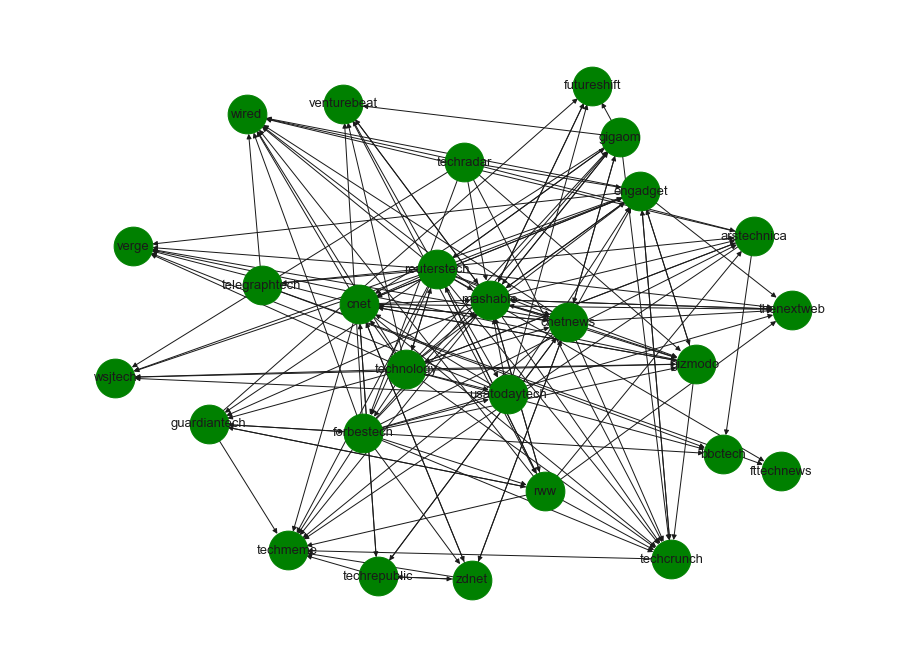

In [210]:
plt.figure(figsize=(16,12))
plt.margins(0.1,0.1)
pos = nx.spring_layout( follower_g, k = 2.2 )
nx.draw(follower_g, pos, with_labels = True, node_size=1500, font_size=13, node_color="green")

##  Follower Characterisation

We can characterise this network by checking the measures of the nodes, edges and density(How many edges vs the maximum amount)

In [211]:
print("Nodes", follower_g.number_of_nodes() )
print("Edges", follower_g.number_of_edges() )
print("Density %.2f" % nx.density(follower_g) )

Nodes 27
Edges 155
Density 0.22


### In & Out Degree
Directed networks offer two types of degree:

In degree is how many nodes point towards this node (how many followers this node has)
Out degree is how many nodes this node points to (how many accounts this node follows)

Below shows the distribution of In & Out degree for the graph.
In degree shown in blue.
Out degree shown in green.

While both are distributed similarly the out degree has a spike at low values showing a lot of accounts only follow a small amount of the other nodes.

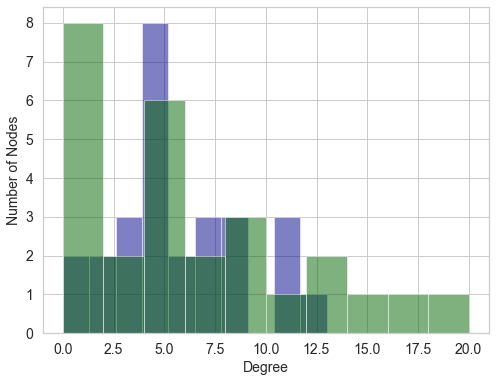

In [212]:
indegree = dict( follower_g.in_degree() )
indegree_s = pd.Series(indegree)

outdegree = dict( follower_g.out_degree() )
outdegree_s = pd.Series(outdegree)

ax = indegree_s.plot.hist(figsize=(8,6), fontsize=14, legend=None, color="darkblue",alpha=0.5)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.set_xlabel("Degree", fontsize=14);

ax = outdegree_s.plot.hist(figsize=(8,6), fontsize=14, legend=None, color="darkgreen",alpha=0.5)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.set_xlabel("Degree", fontsize=14);

In Degree shows how many followers an account has so is a good measure of popularity.

The account names with the top 5 in degree are displayed below

In [213]:
in_deg = pd.Series(dict( follower_g.in_degree() ), name="in-degree")
pd.DataFrame(in_deg).sort_values(by="in-degree", ascending=False).head(10)

in-degree
mashable           13
techmeme           11
wired              11
techcrunch         11
cnet                9
engadget            9
gizmodo             8
verge               7
thenextweb          7
cnetnews            7

The highlight graph below highlights all the nodes in the network that follow 'Mashable' the most followed account.

In [214]:
follower_g['mashable']
mash_follow=[]

for follow in follower_g['mashable']:
    mash_follow.append(follow)

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


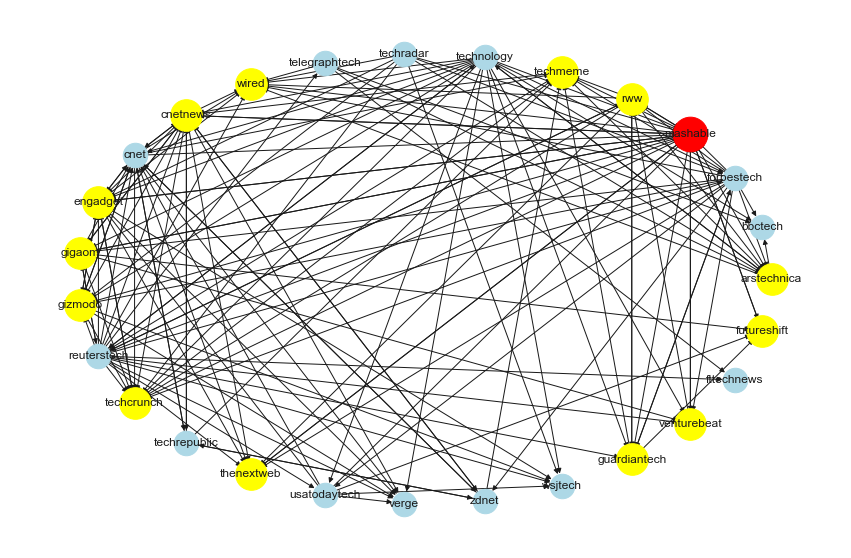

In [215]:
plt.figure(figsize=(15,10))
pos = nx.circular_layout(follower_g)
nx.draw_networkx(follower_g, pos, with_labels=True, font_size=12, node_size=600, node_color="lightblue")
nx.draw_networkx_nodes(follower_g, pos, nodelist=mash_follow, with_labels=True, font_size=12, node_size=1000, node_color="yellow")
nx.draw_networkx_nodes(follower_g, pos, nodelist=['mashable'], with_labels=True, font_size=12, node_size=1200, node_color="red")
plt.axis("off")
plt.show()

Directed networks also offer other measure can be used such as reciprocity which is shown below.

Reciprocity shows what percentage of the edges are mutual.
How many of the accounts follow each other back.

A list of all the mutual relationships in the network are shown below.

In [216]:
print("Reciprocity %.2f" % nx.reciprocity(follower_g) )

for pair in itertools.combinations(follower_g.nodes(), r=2):
    if follower_g.has_edge( pair[0], pair[1] ) and follower_g.has_edge( pair[1], pair[0] ):
        print( "%s <--> %s" % pair )

Reciprocity 0.31
arstechnica <--> technology
forbestech <--> guardiantech
mashable <--> rww
mashable <--> cnetnews
mashable <--> engadget
mashable <--> gigaom
mashable <--> thenextweb
mashable <--> venturebeat
mashable <--> futureshift
rww <--> reuterstech
rww <--> guardiantech
technology <--> reuterstech
cnetnews <--> cnet
cnetnews <--> gigaom
cnetnews <--> techrepublic
cnetnews <--> zdnet
cnet <--> engadget
cnet <--> gizmodo
cnet <--> techrepublic
cnet <--> zdnet
engadget <--> gizmodo
engadget <--> techcrunch
gigaom <--> reuterstech
techrepublic <--> zdnet


As all the relationships are reciprocated we can display this as an undirected network as seen below with edges showing that both accounts follow each other.

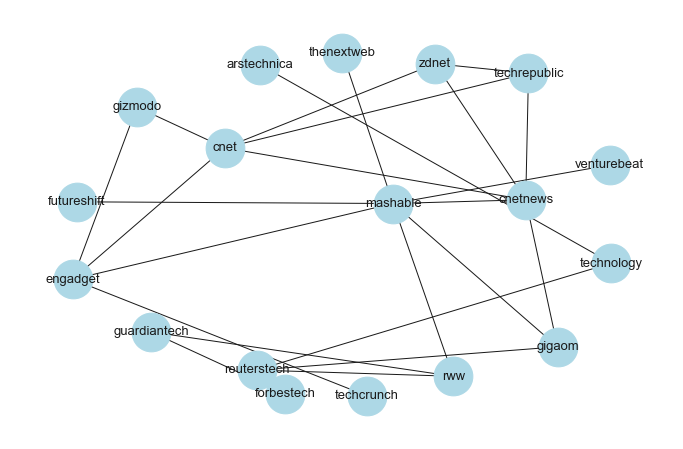

In [217]:
ug1 = follower_g.to_undirected( reciprocal=True )
ug1.remove_nodes_from(list(nx.isolates(ug1)))

plt.figure(figsize=(12,8))
plt.margins(0.1,0.1)
pos = nx.spring_layout( ug1, k = 2.2 )
nx.draw(ug1, pos, with_labels = True, node_size=1500, font_size=13, node_color="lightblue")

### Eigenvector Centrality Values

Centrality is used to figure out which node is most important in the network by a number of different methods. Each centrality score can be used together to help decide which nodes are the most important

Eigenvector centrality takes all the centrality measures of a nodes neighbours and gives the node a score based on these.
Eigenvetor centrality shows how important a node is by seeing how important it's neighbours are.

We can look at eigenvector values for some of the top accounts below, while follows is a good indication of popularity eigenvector values take other things into account and can often give us another view on these nodes.

While not in the top 10 in the in degree list techrepublic and zdnet are both considered immportant nodes for eigenvector values.
I learned that both of these are tech news companies ran by CBS which also ownes CNET which would explain the popularity.

In [218]:
eig_follow = nx.eigenvector_centrality(ug1)

follow_eig = pd.Series(eig_follow)
f_eig_df = pd.DataFrame(follow_eig,columns=["eigenvector"])
f_eig_df["norm_eigenvector"] = f_eig_df["eigenvector"]/max(f_eig_df["eigenvector"])
f_eig_df.sort_values(by="norm_eigenvector",ascending=False).head(10)

eigenvector  norm_eigenvector
cnetnews         0.455474          1.000000
cnet             0.419419          0.920841
mashable         0.389899          0.856027
techrepublic     0.319035          0.700445
zdnet            0.319035          0.700445
engadget         0.287229          0.630614
gigaom           0.257136          0.564546
gizmodo          0.188827          0.414571
rww              0.146708          0.322100
reuterstech      0.116904          0.256665

Below shows the distibution of eignevalues for eah of the accounts.
As there is a small number of accounts this distribution doesn't give much insight as a whole but does show the spikes in accounts at lower eigen values.
As well as a strange spike at towards the end of the graph

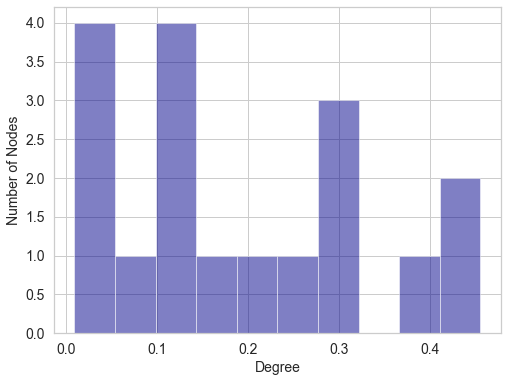

In [316]:
ax = follow_eig.plot.hist(figsize=(8,6), fontsize=14, legend=None, color="darkblue",alpha=0.5)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.set_xlabel("Eigenvector Value", fontsize=14);

# Reply Network

The reply network is a directed network where the nodes are users and edges are created between nodes when a user replies to a tweet. 
The more replies between nodes the greater the weight between these nodes.

In [219]:
reply_g = nx.DiGraph()

To create this network I first took in the json file of tweets and created a pandas dataframe.
Each row of the dataframe represents a tweet and each column represents a attribute of that tweet from the json file.


In [220]:
tweets = []

fin = open("tweets.jsonl","r")

for line in fin.readlines():
    tweet = json.loads( line )
    tweets.append( tweet )
fin.close()
print("Read %d tweets" % len(tweets))

Read 13500 tweets


In [221]:
tweet_df = pd.DataFrame( tweets )

### Cleaning and Parsing

As the tweet objects contain a lot of information a lot of the columns can be removed and I kept only the columns that contained information reply column and on the user that posted the reply

In [222]:
reply_df = tweet_df.drop( ['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated'], axis=1 )

The columns I decided to keep are displayed below

In [223]:
reply_df.head(5)

in_reply_to_screen_name  in_reply_to_status_id in_reply_to_status_id_str  \
0                    None                    NaN                      None   
1                    None                    NaN                      None   
2                    None                    NaN                      None   
3                    None                    NaN                      None   
4                    None                    NaN                      None   

   in_reply_to_user_id in_reply_to_user_id_str  \
0                  NaN                    None   
1                  NaN                    None   
2                  NaN                    None   
3                  NaN                    None   
4                  NaN                    None   

                                                user  
0  {'id': 10876852, 'id_str': '10876852', 'name':...  
1  {'id': 3819701, 'id_str': '3819701', 'name': '...  
2  {'id': 14885549, 'id_str': '14885549', 'name':...  
3  {'id': 15560223, 'id_str': '15560223', 'name':...  
4  {'id': 4641021, 'id_str': '4641021', 'name': '...

### Removing non-replies & Adding Nodes/Edges

The code below goes through each of the tweets in the dataframe.
Initially checking if the current tweet is a reply.

If the tweet is a reply it adds an edge from the user who posted the reply to the creater of the original tweet.
The weight of the edge is increased if the user has replied to this user before.

In [224]:
for index, row in reply_df.iterrows():
    #Takes the string value of the 'in_reply_to_screen_name' at the current index and strips trailing white spaces
    if(not(str(reply_df['in_reply_to_screen_name'].iloc[index]).strip() == 'None')):
        if(row['user']['screen_name'], row['in_reply_to_screen_name']) in reply_g.edges():
            data = reply_g.get_edge_data(row['user']['screen_name'], row['in_reply_to_screen_name'])
            reply_g.add_edge(row['user']['screen_name'], row['in_reply_to_screen_name'], weight=(data['weight'])+1)
        else:
            reply_g.add_edge(row['user']['screen_name'], row['in_reply_to_screen_name'], weight = 1)

## Reply Characterisation

As mentioned above this is a directed weighted network so the direction of the edge as well as the weight is displayed below.

The density of the network is quite low showing that there are not many replies between nodes, the majority of the nodes dont reply to each other.

Nodes True
Nodes 28
Edges 26
Density 0.03439153439153439


C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


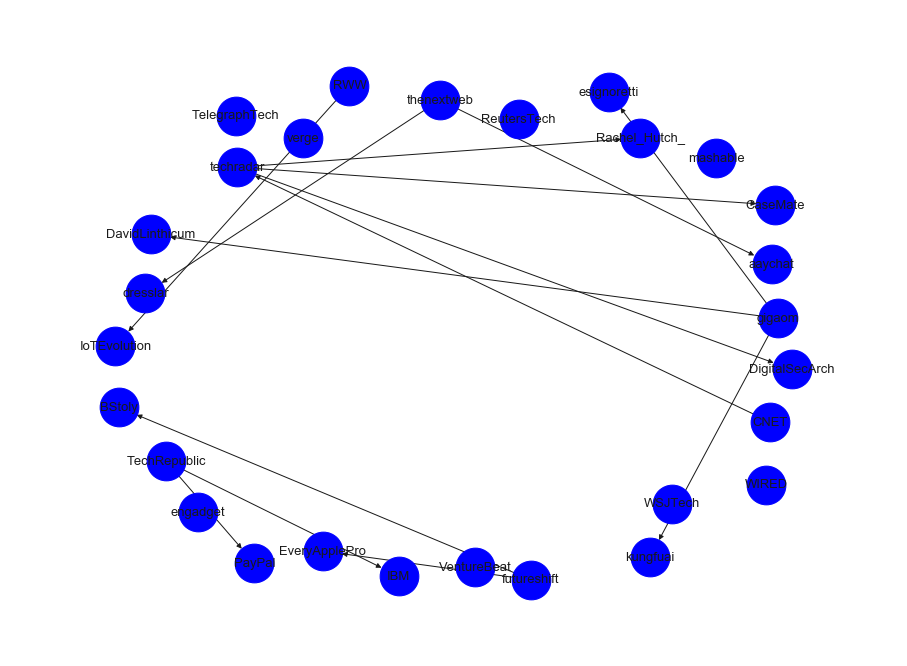

In [225]:
print("Nodes",reply_g.is_directed())
print("Nodes", reply_g.number_of_nodes() )
print("Edges", reply_g.number_of_edges() )
print("Density", nx.density(reply_g) )

plt.figure(figsize=(16,12))
plt.margins(0.1,0.1)
pos = nx.spring_layout( reply_g, k = 2.2 )
nx.draw(reply_g, pos, with_labels = True, node_size=1500, font_size=13, node_color="blue")

plt.figure(figsize=(12,8))
plt.margins(0.1,0.1)
pos = nx.spring_layout( reply_g, k = 2.2 )
labels = nx.get_edge_attributes(reply_g, 'weight')
nx.draw(reply_g, pos, with_labels = True, node_size=1500, font_size=13, node_color="lightgreen")
nx.draw_networkx_edge_labels(reply_g, pos,edge_labels=labels);

### Missing edges
As there are not 26 edges displayed here some of the edges must be between the same node showing that a lot of the replies are replies to the accounts own tweets.

We can also see this when we check the edge with the highest weight.
This shows us that most of the replies are directed to their own network

The highest edge weight other than this is 3 and it is between GigaOM Media and KungFu.ai

In [226]:
print("Reply Network:")
weight_df = nx.to_pandas_edgelist(reply_g)
weight_df.sort_values(by="weight", ascending=False).head(5)

Reply Network:


source         target  weight
2  TelegraphTech  TelegraphTech      34
4    futureshift    futureshift      32
0           CNET           CNET      24
7          WIRED          WIRED      24
3       mashable       mashable       8

### In & Out Degree

Below shows the top in and out degree for the reply network

The in degree shows us how many replies this account has recieved
The out degree shows how many different accounts this account has replied to.

Again these numbers are small as the majority of the replies are too their own network

In degree displayed in blue.
Out degree displayed in green.

Reply Top In Degrees: 
techradar         2
VentureBeat       1
DavidLinthicum    1
TelegraphTech     1
mashable          1
dtype: int64


Reply Top Out Degrees: 
techradar      4
thenextweb     3
futureshift    3
gigaom         3
CNET           2
dtype: int64


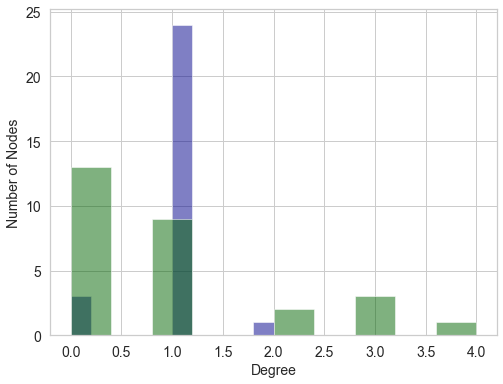

In [227]:
indegree = dict( reply_g.in_degree() )
indegree_s = pd.Series(indegree)

outdegree = dict( reply_g.out_degree() )
outdegree_s = pd.Series(outdegree)

print("Reply Top In Degrees: ")
print(indegree_s.sort_values(ascending=False).head(5))
print("\n")
print("Reply Top Out Degrees: ")
print(outdegree_s.sort_values(ascending=False).head(5) )

ax = indegree_s.plot.hist(figsize=(8,6), fontsize=14, legend=None, color="darkblue",alpha=0.5)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.set_xlabel("Degree", fontsize=14);

ax = outdegree_s.plot.hist(figsize=(8,6), fontsize=14, legend=None, color="darkgreen",alpha=0.5)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.set_xlabel("Degree", fontsize=14);

# Mention Network

The mention network is a weighted directed network that contains nodes of users.
The edges between these users are created if they mention another user in their tweet.

Again for this network we need data from the tweet.jsonl file so we take the tweet dataframe and keep only the necessary columns

In [228]:
tweet_df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

In [229]:
mention_g = nx.DiGraph()

In [230]:
mention_df = tweet_df.drop(['contributors', 'coordinates', 'created_at', 'display_text_range',
        'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated'], axis=1 )

We kept the 'entities' column as it contains information on the mentions in each tweet
We also keep the 'user' column as it contains info on the poster of the tweet such as there screen name or 'handle'

In [231]:
mention_df.columns

Index(['entities', 'user'], dtype='object')

### Parsing the mentions
In order to get the screen name of each person mentioned we must parse the 'entities' column and create a 'user_mentions' column that contains a dictionary of all the users mentions in that tweet.

Below code shows how I parsed the data by creating a temporary list of the mentions in each tweet and then added this to the dataframe.

In [232]:
temp_mentions = []

for i, entity in mention_df["entities"].iteritems():
   
    temp_mentions.append(entity["user_mentions"])

mention_df["user_mentions"] = temp_mentions
mention_df = mention_df.drop( ['entities'], axis=1)

In [233]:
mention_df.columns

Index(['user', 'user_mentions'], dtype='object')

### Filling the network
The following code fills the network adding edges between nodes going from the node that created the tweet to the node of the acccont that was mentioned.

Only tweets that contain user mentions are added.
The weight of a relationship is increased if an account replies to another multiple times.

In [234]:
for index, tweet in mention_df.iterrows():
    #Skips tweets if there are no mentions within that tweet
    if(not(str(tweet['user_mentions']).strip() == '[]')):
        for team in tweet['user_mentions']:
            if(tweet['user']['screen_name'], team['screen_name']) in mention_g.edges():
                data = mention_g.get_edge_data(tweet['user']['screen_name'], team['screen_name'])
                mention_g.add_edge(tweet['user']['screen_name'],team['screen_name'], weight=(data['weight'])+1)
            else:
                mention_g.add_edge(tweet['user']['screen_name'],team['screen_name'], weight = 1)

## Mention Characterisation

The mention network includes nodes from users in the list of tweets but also includes a wide range of more users from Twitter who have been metioned in tweets.

We can see that a large variety of accunts are mentioned in these technology tweets as we have a very large network with 1400 nodes and 1554 edges.
As all these nodes could be mentioning each other the density is quite low.

Because of the large amount of nodes and edges the network becomes very difficult to display ad to read

In [235]:
print("Nodes", mention_g.number_of_nodes() )
print("Edges", mention_g.number_of_edges() )
print("Density", nx.density(mention_g) )

Nodes 1400
Edges 1554
Density 0.0007934238741958542


C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


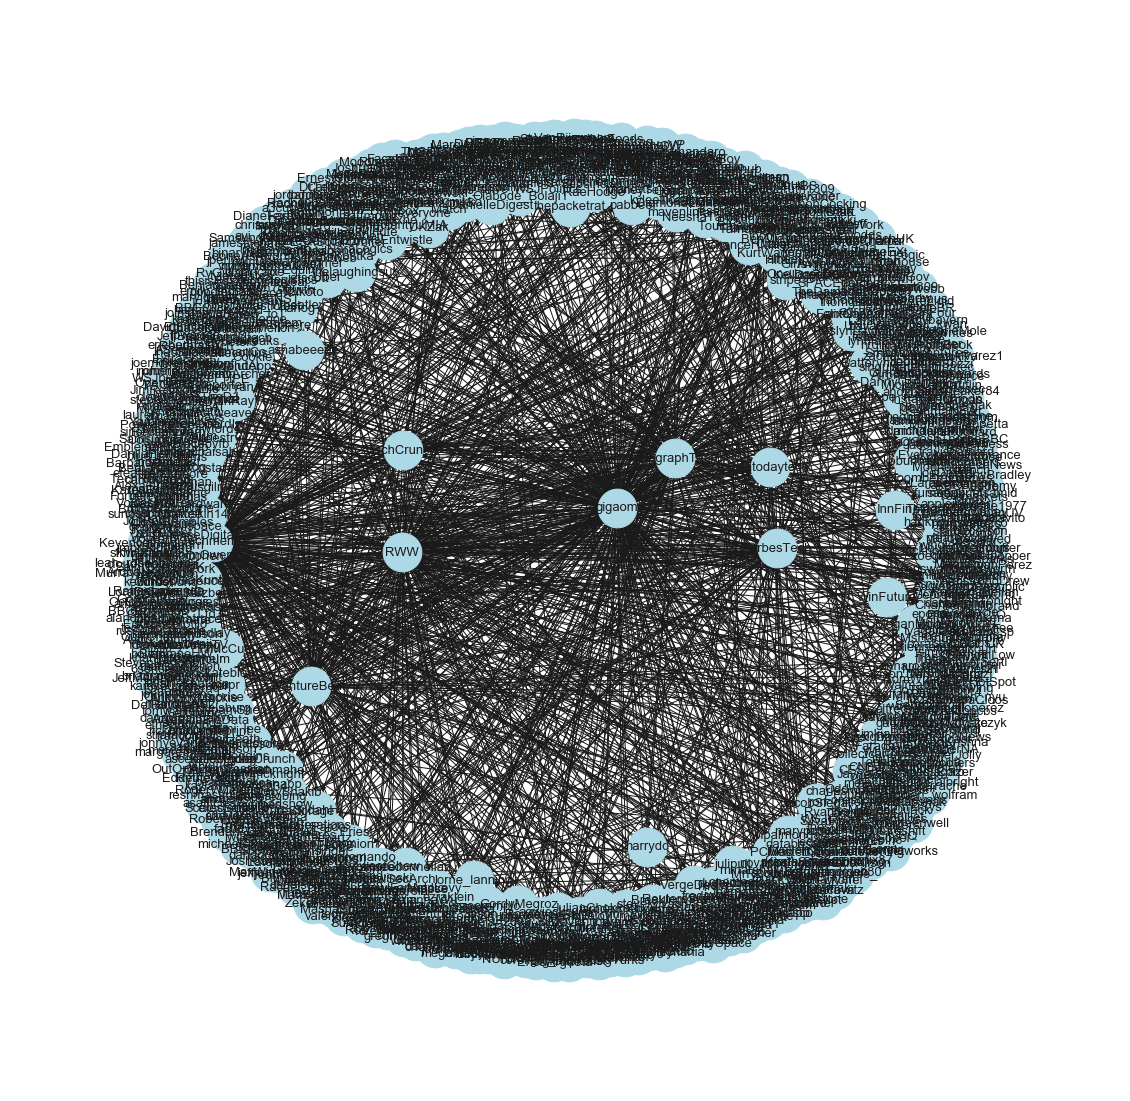

In [236]:
plt.figure(figsize=(20,20))
plt.margins(0.1,0.1)
pos = nx.spring_layout( mention_g, k = 2.2 )
nx.draw(mention_g, pos, with_labels = True, node_size=1500, font_size=13, node_color="lightblue")

## Highest Weights

Below shows the highest weights between networks showing that the source network often mentions the target.

Many of the highest amount of metions come from the GigaOM account.

The target users that there are mentioning are the CTO David Linthicum.
The publisher Byron Reese.
And with the most mentions Enrico Signoretti who is a independent IT analyst at GigaOM

The people mentioned by TheNextWeb are also reporters within the company showing again, just like with the replies most of the users an account mentions are people within that organisation and mentioning other organisations is more rare.

In [237]:
print("Mention Network:")
men_df = nx.to_pandas_edgelist(mention_g)
men_df.sort_values(by="weight", ascending=False).head(5)

Mention Network:


source          target  weight
163      gigaom     esignoretti      91
414  thenextweb       napilopez      74
167      gigaom      byronreese      70
413  thenextweb      IndianIdle      63
150      gigaom  DavidLinthicum      59

This is cemented again when looking at the in degree for the network with the indegree having a max of 6 showing from are userlist

The In degree on the histogram is displayed in Blue.

Reply Top In Degrees: 
Google        6
campuscodi    5
Samsung       4
LiamT         4
ldignan       3
dtype: int64


Reply Top Out Degrees: 
gigaom           271
Techmeme         255
RWW              174
TelegraphTech    128
ForbesTech        96
dtype: int64


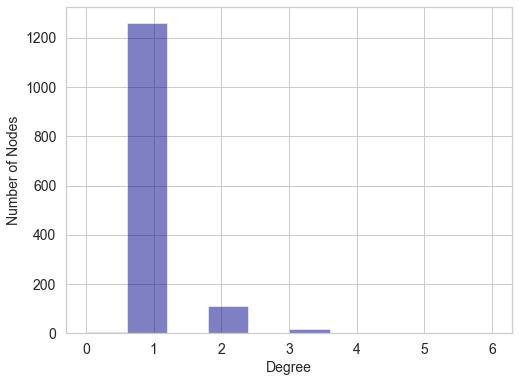

In [276]:
indegree_m = dict( mention_g.in_degree() )
indegree_sm = pd.Series(indegree_m)

outdegree_m = dict( mention_g.out_degree() )
outdegree_sm = pd.Series(outdegree_m)

print("Reply Top In Degrees: ")
print(indegree_sm.sort_values(ascending=False).head(5))
print("\n")
print("Reply Top Out Degrees: ")
print(outdegree_sm.sort_values(ascending=False).head(5) )

ax = indegree_sm.plot.hist(figsize=(8,6), fontsize=14, legend=None, color="darkblue",alpha=0.5)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.set_xlabel("Degree", fontsize=14);


## Ego Network

Because of the large amount of nodes in the network I decided istead to focus on particular nodes and their mentions instead.

Below shows an ego graph of the CNET account displaying all the nodes that CNET has mentioned

Nodes: 
44
Density: 
0.024841437632135307


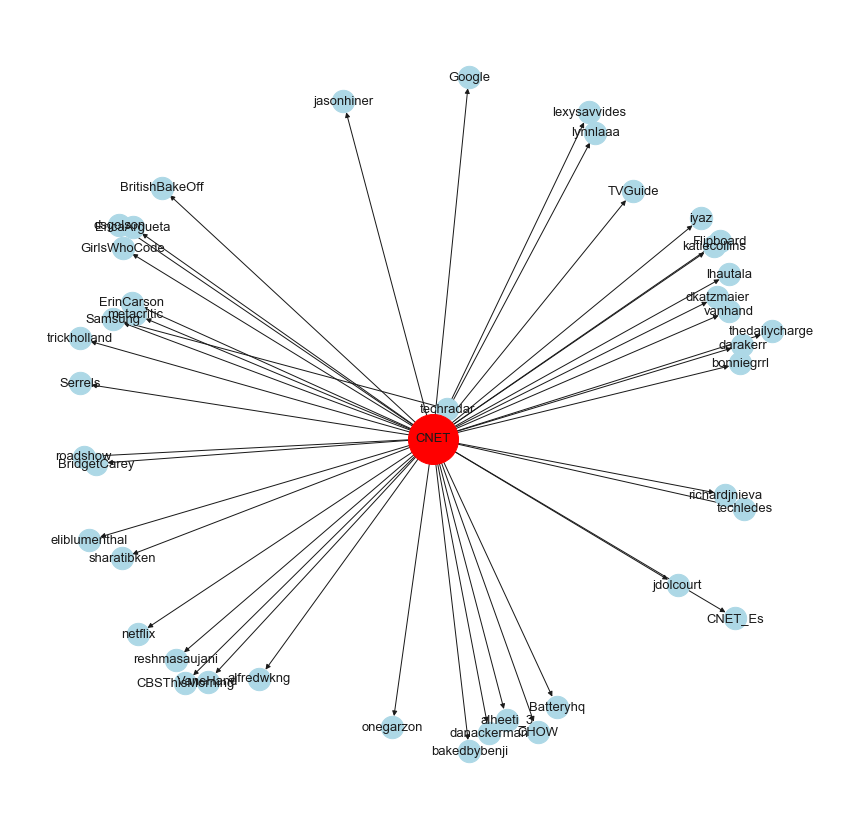

In [318]:
ego_node = "CNET"

eg = nx.ego_graph( mention_g, ego_node )

print("Nodes: ")
print(eg.number_of_nodes())
print("Density: ")
print(nx.density(eg))

plt.figure(figsize=(15,15))
pos = nx.spring_layout(mention_g)
nx.draw_networkx(eg, pos, with_labels=True, font_size=13, node_size=500, node_color="lightblue")
nx.draw_networkx_nodes(eg, pos, nodelist=[ego_node], with_labels=True,font_size=13, node_size=2500, node_color="red")
plt.axis("off")
plt.show()

We can also see again that the most mentioned accounts by CNET are people with the organisation similar to GigaOM

In [323]:
egmen_df = nx.to_pandas_edgelist(eg)
egmen_df.sort_values(by="weight", ascending=False).head(5)

source        target  weight
44  techradar     techradar       8
0        CNET     alheeti_3       5
6        CNET  trickholland       4
18       CNET    bonniegrrl       4
13       CNET     jdolcourt       4

Eigenvector values on the other hand allow us to see which of the accounts mentioned are considered important nodes in the network. Techradar and Samsung scoring high on this as they are very connected popular accounts.

In [324]:
eig = nx.eigenvector_centrality(eg)

ment_eig = pd.Series(eig)
meig_df = pd.DataFrame(ment_eig,columns=["eigenvector"])
meig_df["norm_eigenvector"] = meig_df["eigenvector"]/max(meig_df["eigenvector"])
meig_df.sort_values(by="norm_eigenvector",ascending=False).head(5)

eigenvector  norm_eigenvector
CNET             0.274720          1.000000
techradar        0.274720          1.000000
Samsung          0.274720          1.000000
techledes        0.137361          0.500003
lexysavvides     0.137361          0.500003

# User Hashtag Network

The User Hashtag Network is a Bipartite Network.
This means the nodes are split into two distinct seperate sets.

For this network one set contains Users and the other contains Hashtags

The edges are created from users to hashtags when a user uses a hashtag in their tweet.

The weight for each edge is increased if a user uses a Hashtag multiple times across tweets.

In [240]:
tweet_df.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated',
       'user'],
      dtype='object')

In [241]:
hash_df = tweet_df.drop(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated'], axis=1 )

### Cleaning Dataset

We clean the data similarly to the mention network again as the 'entities' and 'user' columns contains the data we need.

In [242]:
hash_df.columns

Index(['entities', 'user'], dtype='object')

### Parsing Data

We also need to parse to the data to get the dictionary of Hashtags from the 'entities' column.
This time I also parsed the user

When the list of all the hashtags for each tweet is created the list is added as a column in the dataframe and the entities column can then be removed as we no longer need the data.

In [243]:
temp_hashtags = []
for index, tweet in hash_df['entities'].iteritems():
    
    temp_hashtags.append(tweet["hashtags"])

hash_df["hashtags"] = temp_hashtags
hash_df = hash_df.drop( ['entities'], axis=1)

The same is done for the 'screen_name' or handle of each user to make it simpler to add the nodes.

In [244]:
temp_handle = []
for index, user in hash_df["user"].iteritems():
   
    temp_handle.append(user["screen_name"])
    
# drop the column when we are finished
hash_df["handle"] = temp_handle
hash_df = hash_df.drop( ['user'], axis=1)

In [245]:
hash_df.head(5)

hashtags      handle
0                                         []  thenextweb
1                                         []       ZDNet
2                                         []  ForbesTech
3                                         []   techradar
4  [{'text': 'apps', 'indices': [121, 126]}]         RWW

### Creating Node Sets

Below we create two sets of nodes for the bipartite network
One contains all the account handles and one contains all the hashtags used.

The counter is used to keep track of how many times a hashtag is used be a specific user.

Looping through all the tweets in the dataframe, we ignore all the ones with empty lists inside.
We then add the user to the accounts set and check all the hashtags for this user.

For each hashtag we add a '#' at the start to differentiate it from a user handle and add it to the hashtag set.

We finally add the pair of user handle and hashtag to the commit_counts dictionary so we can see how many times an account uses a specific hashtag.

In [246]:
commit_counts = Counter()

hash_g = nx.Graph()
accounts = set()
hashtags = set()

for index, tweet in hash_df.iterrows():
    # Removing tweets containing no hashtags
    if(not(str(tweet['hashtags']).strip() == '[]')):
        # Ensuring the account is not added twice
        if not tweet["handle"] in accounts:
            accounts.add( tweet["handle"] )
            hash_g.add_node( tweet["handle"], bipartite=0 )
            
        for hashtag in tweet['hashtags']:
            #Adding the '#'
            hashtag['text'] = hashtag['text'].lower()
            hashtag['text'] = "#{0}".format(hashtag['text'])
            if not hashtag["text"] in hashtags:
                hashtags.add( hashtag["text"] )
                hash_g.add_node( hashtag["text"], bipartite=1 )
            pair = frozenset([tweet["handle"], hashtag["text"]])
            commit_counts[pair] += 1 
             

### Adding Edges
We can then easily add the edges as we have a list of all the pairs in a dictinary with a count of how often this pair occurs.

In [247]:
for pair in commit_counts:
    hash_g.add_edge( *pair, weight=commit_counts[pair] )

## Bipartite Characterisations

As the User-Hashtag network is bipartite it opens up a lot of new ways to characterise the network.

There is a large amount of nodes in this network so inorder to look at the characterisation we need to simplify it.

In [271]:
print("Nodes", mention_g.number_of_nodes() )
print("Edges", mention_g.number_of_edges() )
print("Density", nx.density(mention_g) )

print("Bipartite:",bipartite.is_bipartite( hash_g ))

print( "%d accounts, %d hashtags" % ( len(accounts), len(hashtags) ) )

nx.number_connected_components(hash_g)

Nodes 1400
Edges 1554
Density 0.0007934238741958542
Bipartite: True
23 accounts, 643 hashtags


4

### Drawing the network

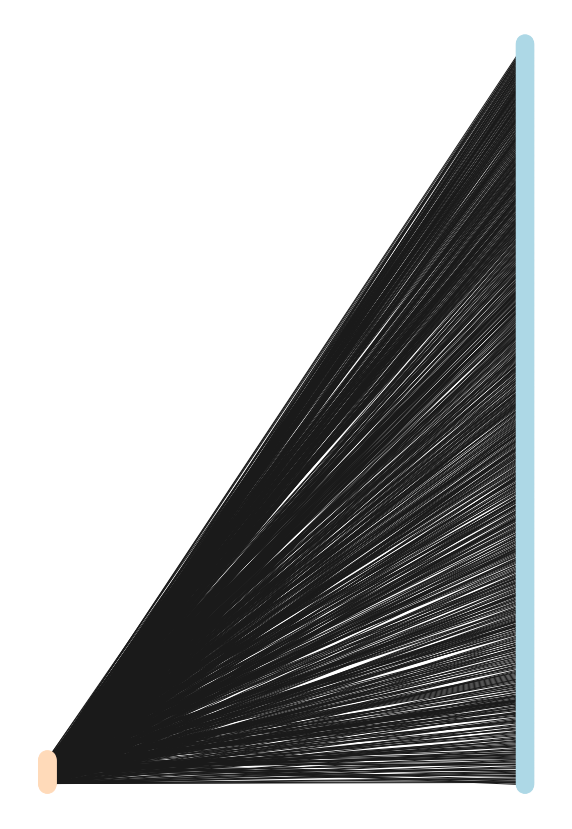

In [285]:

color_map, pos = {}, {}
for i, node in enumerate(accounts):
    pos[node] = (0, i*2)
    color_map[node] = "#ffdab9"
for i, node in enumerate(hashtags):
    pos[node] = (0.5, i*2)
    color_map[node] = "lightblue"
colors = [color_map[node] for node in hash_g.nodes()]
plt.figure(figsize=(10,15))
nx.draw_networkx(hash_g, pos=pos, with_labels=False, 
        node_size = 300,
        font_size = 12,
        node_color = colors)
plt.axis("off")
plt.show()

### Popular Hashtags
As we can see this network is very conjested so to simplify we can look instead at individual accounts and invidual hashtags that they use.

The most popular hashtags are displayed below showing how many times they have been used by different accounts.

More general hashtags seem to take over here while some such as ces2020 which is a tech conference seems to be a very popular specific topic of discussion

In [273]:
#Creates dictionary of hashtags and their weighted degree
hash_wdegrees = dict(hash_g.degree(hashtags, weight="weight"))

#Creates a pandas dataframe so the hashtag and the degree can be displayed
hash_swdeg = pd.Series(hash_wdegrees, name="w-degree")
hash_swdeg = hash_swdeg.sort_values(ascending=False)

pd.DataFrame(hash_swdeg.head(10))

w-degree
#podcast             144
#technology          130
#ai                  110
#ces2020             100
#apple                88
#cloud                88
#cybersecurity        75
#data                 71
#oscars               62
#enterprise           57

### User hashtag usage

We can also look at which accounts use the most hashtags based on their weighted degree also showing GigaOM is much higher then the rest with nearly double RWW with the second most hashtag usage.

The amount of hashtags used seems to drop off dramatically as you move down the top 10 accounts.


In [274]:

handle_wdegrees = dict(hash_g.degree(accounts, weight="weight"))

handle_swdeg = pd.Series(handle_wdegrees, name="w-degree")
handle_swdeg = handle_swdeg.sort_values(ascending=False)

pd.DataFrame(handle_swdeg.head(10))

w-degree
gigaom             1462
RWW                 744
TelegraphTech       538
CNET                129
arstechnica         123
futureshift         105
TechRepublic         86
VentureBeat          44
WSJTech              37
usatodaytech         31

#### GigaOM hashtag usage

GigaOM uses a large range of different hashtags.

But what is interesting is that despite '#podcast' being the most used hashtag only GigaOM uses this hashtag from the accounts set.

This shows how accouts tweeting disproportionately can effect the graph immensely

In [293]:
list(hash_g.neighbors("gigaom"))

['#bi',
 '#cloud',
 '#analytics',
 '#ai',
 '#continuoustesting',
 '#enterprise',
 '#voicesindevops',
 '#podcast',
 '#cxos',
 '#it',
 '#devops',
 '#cloudcomputing',
 '#voicesincloud',
 '#voicesinai',
 '#ml',
 '#pureaccelerate',
 '#hpe',
 '#hpeprimera',
 '#storage',
 '#vids',
 '#datastorage',
 '#security',
 '#rpa',
 '#webinar',
 '#datamanagement',
 '#datawarehouse',
 '#data',
 '#hybrid',
 '#executive',
 '#digitaltransformation',
 '#cio',
 '#leadership',
 '#artificialintelligence',
 '#neuralnets',
 '#networkpeering',
 '#networkstrategy',
 '#datalake',
 '#report',
 '#itsm',
 '#itil',
 '#netappinsight',
 '#deepdiveintoai',
 '#sfd19',
 '#dr',
 '#draas',
 '#backup',
 '#cybersecurity',
 '#cloudsecurity',
 '#infosec',
 '#siem',
 '#aba',
 '#hitachinext',
 '#datacatalogs',
 '#cloudstorage',
 '#aiminute',
 '#selfdrivingvehicles',
 '#driverlesscars',
 '#multicloud',
 '#hybridcloud',
 '#gigabrief',
 '#biz',
 '#tech',
 '#cem',
 '#cx',
 '#insurance',
 '#siems',
 '#internetpeering',
 '#peering',
 '#cio

In [294]:
list(hash_g.neighbors("#podcast"))

['gigaom']

### Weighted Projected Networks

This is a weighted projected network of the accounts that shows which accounts use the same hashtags and is weighted on how many hashtags they share.

In [305]:
g = bipartite.weighted_projected_graph(hash_g, accounts)
g.remove_nodes_from(list(nx.isolates(g)))
g.number_of_nodes(), g.number_of_edges()

(20, 99)

In [306]:
list(g1.edges())[0]

('BBCTech', 'TechRepublic')

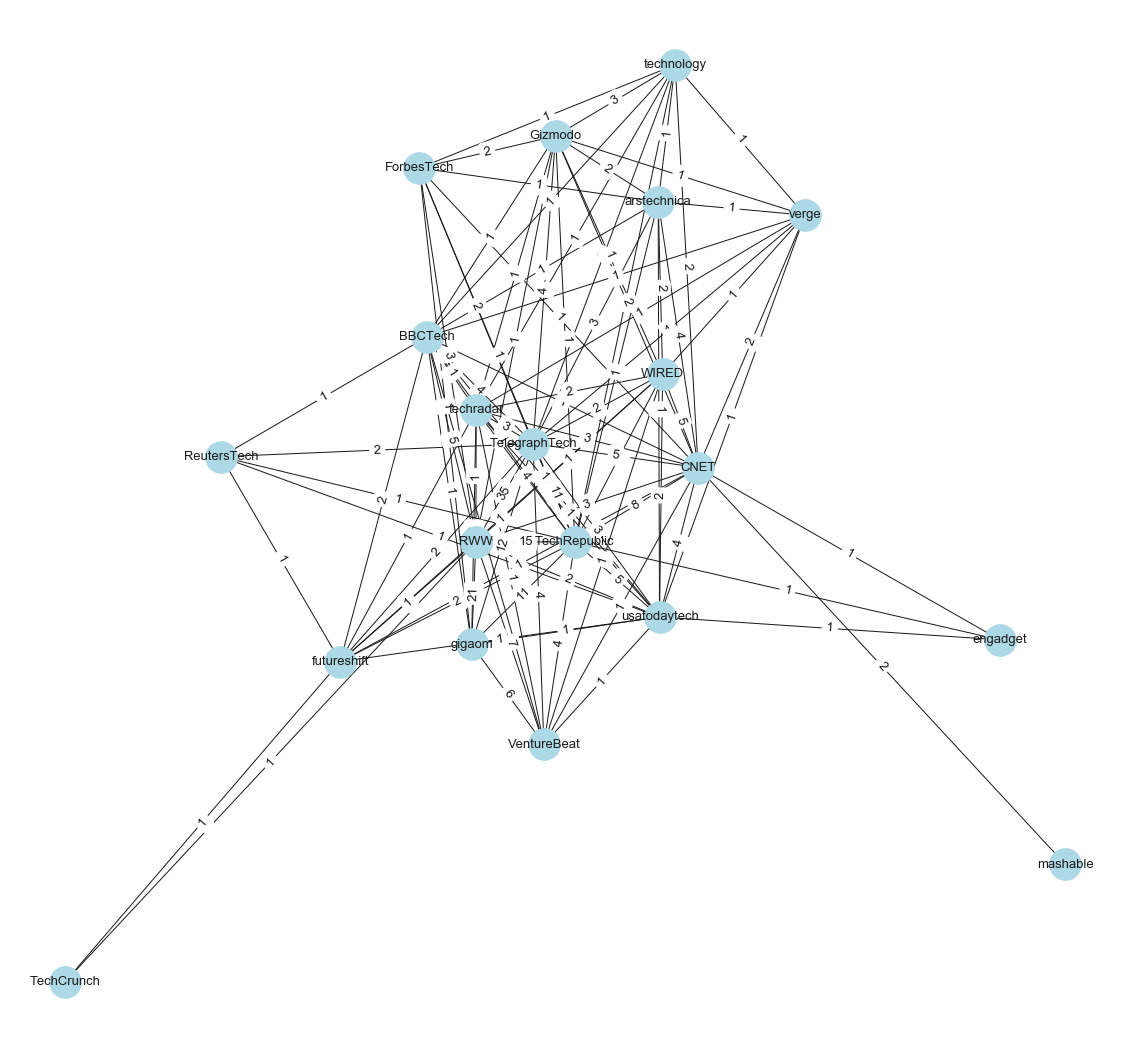

In [311]:
plt.figure(figsize=(20,19))
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True, font_size=13, node_size=1000, node_color="lightblue")
edge_labels = nx.get_edge_attributes(g,'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=13)
plt.axis("off")
plt.show()

This then allows us to see an interesting visualisation on which users share the most hashtags together.
The top 5 of which is displayed below with RWW and TelegraphTech sharing the most.


In [314]:
df_wpn = nx.to_pandas_edgelist(g)
df_wpn.sort_values(by="weight",ascending=False).head(5)

source         target  weight
17            RWW  TelegraphTech      35
25            RWW         gigaom      21
14            RWW   TechRepublic      15
74  TelegraphTech         gigaom      12
59   TechRepublic  TelegraphTech      11

# Hashtag Co-occurance Network

Hashtag Co-occurance Network is an undirected network where nodes in this case are hashtags and edges are created between nodes if they occur in the same tweet together.

Below shows how the tweet_df was once again cleaned so only the information needed was taken

In [255]:
co_df = tweet_df.drop(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink',
       'retweet_count', 'retweeted', 'retweeted_status', 'source', 'truncated','user'], axis=1 )

co_g = nx.Graph()

### Parsing the data

Parsing the data was then used to get a dicionary of the hashtags used for each tweet.

This is done similarly to above where each dictionary of tweets is take from the entities column of the tweet dataframe and stored in a list and then is added to a dataframe.


In [256]:
temp_hashtags = []
for index, tweet in co_df['entities'].iteritems():
    
    temp_hashtags.append(tweet["hashtags"])

co_df["hashtags"] = temp_hashtags
co_df = co_df.drop( ['entities'], axis=1)

## Adding the edges

The following code adds the edges and weights for the network.

The first if condition only allows tweets which contain more than one hashtag.

The weight of each edge is increased if two hashtags are used in the same tweet together.

The function allows you to create edges between all hashtags in tweets even if the size of the list changes. It does this by adding the first hashtag to the rest and then moving down the list until the last two hashtags edges are added.

In [257]:
for index, tweet in co_df.iterrows():
        if(len(tweet['hashtags']) > 1):
            x = 0
            y = 1
            while(x != y):
                hash1 = tweet['hashtags'][x]['text'].lower()
                hash2 = tweet['hashtags'][y]['text'].lower()     

                if(hash1 != hash2):
                    if(hash1,hash2) in co_g.edges():
                        data = co_g.get_edge_data(hash1, hash2)
                        co_g.add_edge(hash1, hash2, weight=(data['weight'])+1)

                    else:
                        co_g.add_edge(hash1, hash2, weight = 1)

                if(y<(len(tweet['hashtags']))-1):
                    y = y+1

                elif(y == (len(tweet['hashtags']))-1 & x < (len(tweet['hashtags']))-2):
                    x = x+1
                    y = (x+1)

                else:
                    x = y

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


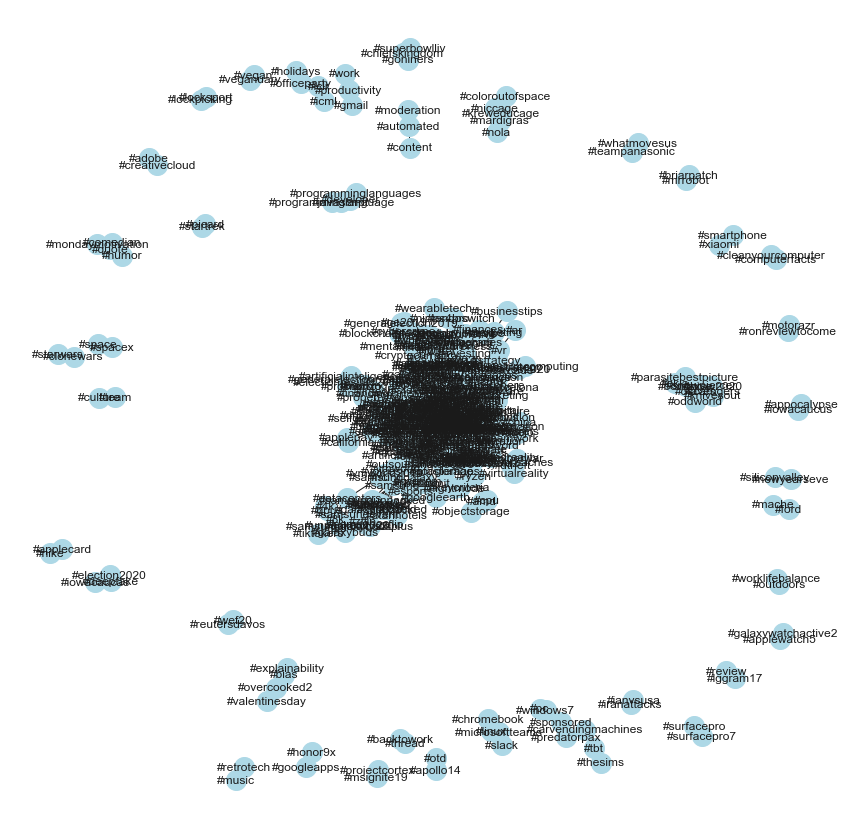

In [259]:
plt.figure(figsize=(15,15))
nx.draw_networkx( co_g, with_labels=True, node_size=400, node_color="lightblue" )
labels = nx.get_edge_attributes(co_g, 'weight')
plt.axis("off")
plt.show()

## Hashtag Co-occurance Characterisation

As we can see from the above visualisation many of the co-occurance hashtags are split into different components.
Many of these components have only two nodes in them and distort the visualisation so it is difficult to visualise.

In [260]:
print("Components", nx.number_connected_components(co_g))
print("Nodes", co_g.number_of_nodes() )
print("Edges", co_g.number_of_edges() )
print("Density", nx.density(co_g) )

Components 44
Nodes 463
Edges 628
Density 0.005871738053163539


### Removing small components
In order to deal with this we can remove the components with a very low amount of nodes.

Removing components that have less than 10 nodes leaves us with one compenent of related hashtags.
This means that this network is now connected and we have removed 120 nodes from the other smaller components

In [261]:
for component in list(nx.connected_components(co_g)):
    if len(component)<10:
        for node in component:
            co_g.remove_node(node)

In [262]:
print("Components", nx.number_connected_components(co_g))
print("Nodes", co_g.number_of_nodes() )
print("Edges", co_g.number_of_edges() )
print("Density", nx.density(co_g) )

Components 1
Nodes 356
Edges 562
Density 0.008893812312074695


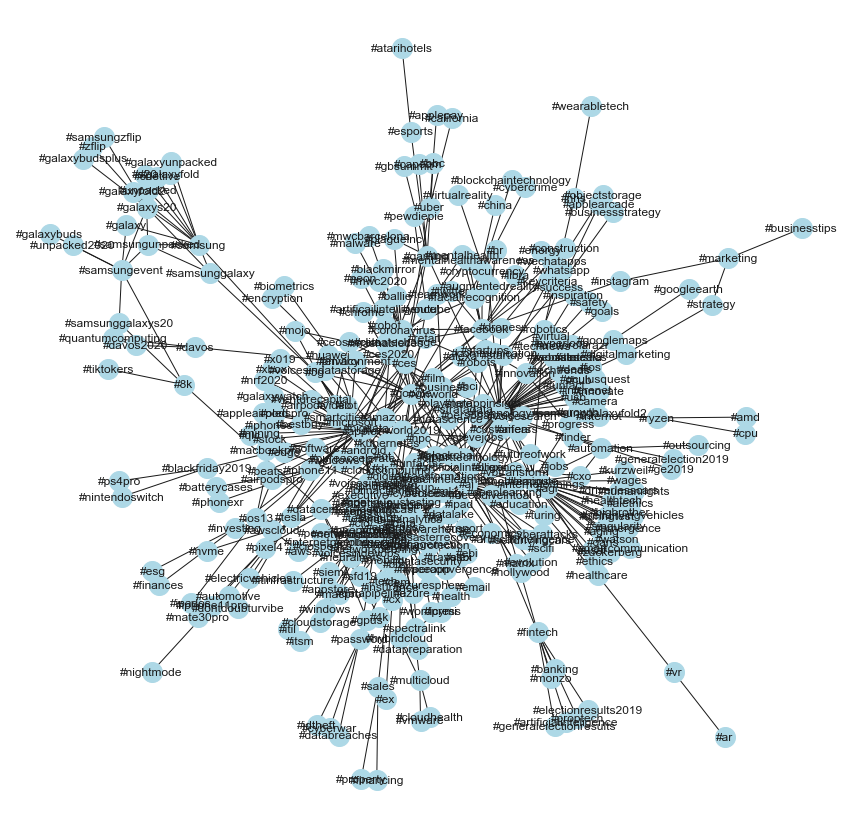

In [263]:
plt.figure(figsize=(15,15))
nx.draw_networkx( co_g, with_labels=True, node_size=400, node_color="lightblue" )
labels = nx.get_edge_attributes(co_g, 'weight')
plt.axis("off")
plt.show()

### Most frequent co-occuring hashtags

These hastags appear again we see Mashable again showing us that this is a very active account.

We see a lot of co-occurances with podcasts, this is a good indication of the popular topics talked about on technology podcasts at the moment.

We see that both Datastorage and Security are both very relevant topics at the moment.

We see Mashables often mentioning CES 2020 which is a conference for technology companies and innovaters held each year.

In [264]:
df_co = nx.to_pandas_edgelist(co_g)
df_co.sort_values(by="weight",ascending=False).head(8)

source        target  weight
319  #ces2020  #mashableces      40
177  #podcast  #datastorage      30
188  #podcast     #security      28
180  #podcast          #cio      24
176  #podcast         #vids      23
36        #ai   #voicesinai      22
45        #ai     #aiminute      22
305      #ces      #ces2020      19

### Eigenvector values

We can also use eigenvectors to see which Hashtags on their own are important.

This shows more general hashtags that would be used by a range of different accounts.

Hashtags shown below are some of the most important.
It seems that many of the top hastahags such as #ai, #cloud, #cybersecurity, #data and #machinelearning are very relevant to data science showing it is a very current topic in the technology community.

In [265]:
eig = nx.eigenvector_centrality(co_g)

co_eig = pd.Series(eig)
eig_df = pd.DataFrame(co_eig,columns=["eigenvector"])
eig_df["norm_eigenvector"] = eig_df["eigenvector"]/max(eig_df["eigenvector"])
eig_df.sort_values(by="norm_eigenvector",ascending=False).head(10)

eigenvector  norm_eigenvector
#podcast                    0.310286          1.000000
#ai                         0.298149          0.960884
#technology                 0.294342          0.948615
#cloud                      0.286279          0.922628
#cybersecurity              0.219426          0.707173
#data                       0.218790          0.705121
#artificialintelligence     0.184800          0.595579
#apple                      0.171816          0.553735
#google                     0.154688          0.498532
#machinelearning            0.146668          0.472687

Graph shows distribution of eigenvector values 

Vast majority of eigenvector values are very low 

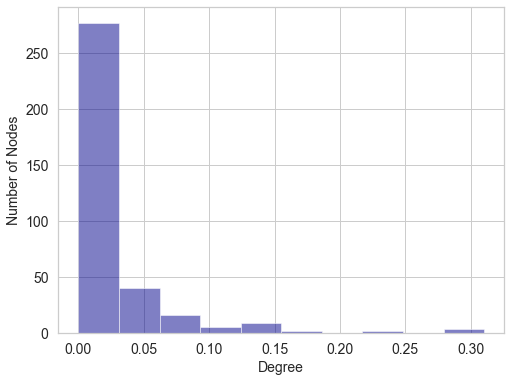

In [315]:
ax = co_eig.plot.hist(figsize=(8,6), fontsize=14, legend=None, color="darkblue",alpha=0.5)
ax.set_ylabel("Number of Nodes", fontsize=14)
ax.set_xlabel("Degree", fontsize=14);

### Ego Network

After taking a look at the ego network for the #ces topic we can see the related topics.

These topics range from robots to black mirror to brexit.

In [266]:
ego_node = "#ces"
egco = nx.ego_graph(co_g, ego_node)

C:\Users\User\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


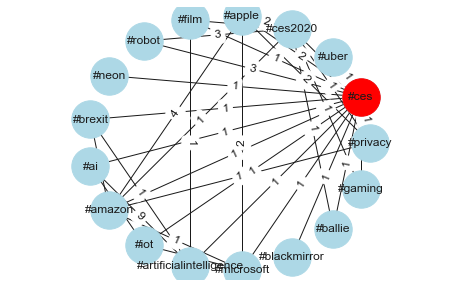

In [267]:
plt.figure( figsize=(8,5) ) 
plt.margins(0.25,0)
pos = nx.circular_layout( egco )
# draw the nodes and edges
nx.draw(egco, pos, with_labels = True, node_size=1400, font_size=12, node_color="lightblue")
labels = nx.get_edge_attributes(egco, 'weight')
nx.draw_networkx_edge_labels(egco, pos,edge_labels=labels, font_size=12)
nx.draw_networkx_nodes(egco, pos, nodelist=[ego_node], with_labels=True, font_size=12, 
                       node_size=1400, node_color="red");

# Tentative Conclusion

Cleaning, parsing, constructing and characterising each of these networks revealed interesting information about the data.

#### Follower
From the first network, the follower network we can see the popularity of some of the Accounts with mashable having a high indegree and CNET scoring very high on the eigenvector values. Other CBS owned accounts also scored very high eigenvector values. We can also see how the in and out degree is left skewed as well as the repriocity being quite low showing that most of the accounts do not follow each other mutually and the majority of accounts dont follow many others. This is something that we will see repeat across all of the networks as most of the accounts tend to mostly interact with themselves

#### Reply
We can see then from the reply network how most of the interaction of each of the accounts is usually between themselves. Replying mostly to their own tweets with very low in and out degrees for each of the nodes. There are very few edges between networks and the strongest weighted replies are to thier own network.

#### Mention
We see again with the mention network that GigaOM seems to have some of the highest mentions. These mentions tend to be mentioning people withing their company. It seems there is a huge range of different accounts mentioned by each of the accounts, this makes the mention network difficult to decifer. This range of accounts can be seen in the CNET ego graph created. The wide range of mentions makes it difficult to see which accounts are popularly mention. But it appears GigaOM use a disproportional amount of mentions indicating that they may tweet a lot more than the other accounts.

#### User Hashtag
In the User Hashtag again we see a disproportionate use of hashtags from GigaOM implying again that they tweet much more regularly than the other accounts in the network. The second most hashtag usage uses nearly half the amount that GigaOM uses.
We can also see this disproportion in the top hashtags used as despite #podcast being one of the top hashtags, it is only used by the GigaOM account. We also looked at accounts that use similar hashtags with RWW, gigaOM and TelegraphTech being the top accounts in this.

#### Co-occurance
In the co-occuarance we see the reappearance on mashable, which seems to be heavily involved in the CES tech conference, we can also see some of the popular hashtags used which shows many data science topics are very relevant in the tech community at the moment. Despite having lots of smaller components to the network the connected component for each of these hashtags seems to be very large showing there is a connection between a lot of the technology topics. As expected we see a lot of similar hashtags used together such as #ces and #CES2020. This network seems to show the relevance of CES2020 in the technology community at the moment as it appears in all parts of this network.



### Unsucessful Adjacentry Matrixes

Most adjacentry matrices don't show much useful information for these networks.

The following reply network shows how Networks mostly only reply to their own tweets as all the info is on the diagonal where the same user meets.

For the other networks the data is either unweighted such as the Follower Network so doesn't show any interesting data
Or like the reply and co-occurance networks that have too many combinations of nodes so the graph becomes unreadable.

Altogehter I felt adjacently matrices gave no insight into the graphs for this particular project.

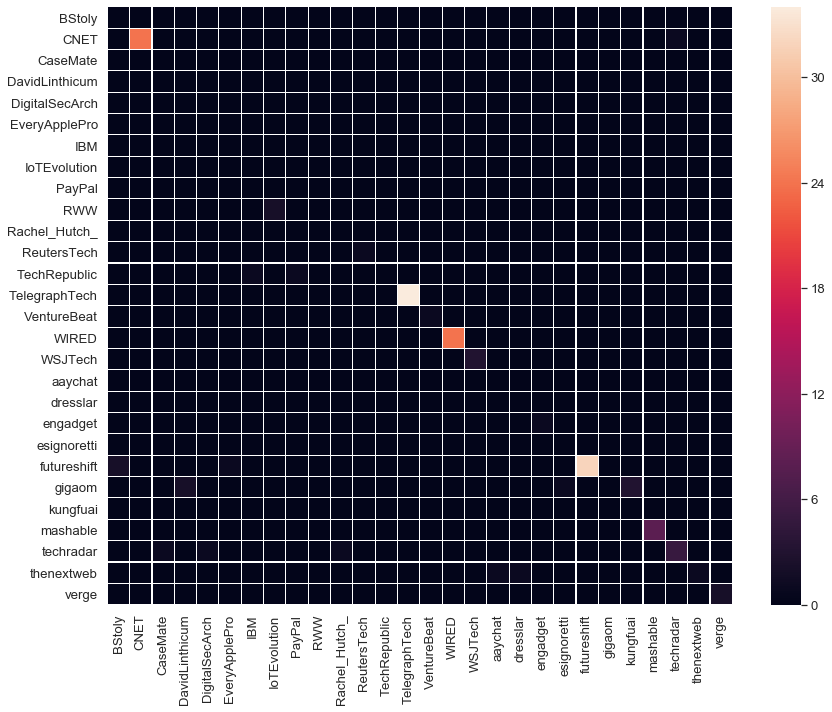

In [268]:
node_ids = sorted(reply_g.nodes())

matrix = nx.to_numpy_matrix(reply_g, nodelist=node_ids)
plt.figure(figsize=(14,11))
ax = sns.heatmap(matrix, linewidths=0.1, xticklabels=node_ids, yticklabels=node_ids)